# Dynamics

This file contains the functions for gravity between the masses and their motion.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py

G = 20 #6.673*(10**-11)

def grav_force(mass_1, mass_2, r, vec):
    """ Takes in 2 masses, distance between them and returns the gravitational force between the objects"""
    return -1*vec*(G*mass_1*mass_2)/(r**2)

def get_r(pos1, pos2):
    """ Given two points in 3 dimensions, returns the distance between them 
    and the unit vector pointing between them in x,y,z.
    """
    if len(pos1)==3 and len(pos2)==3:
        d = [pos1[0]-pos2[0], pos1[1]-pos2[1], pos1[2]-pos2[2]]
        dist = np.sqrt(d[0]**2+d[1]**2+d[2]**2) # distance between 
        direc = np.array([d[0] / dist, d[1] / dist, d[2] / dist])
    else:
        print("points are not in 3 dimensions")
        dist = 0
        direc = np.array(0,0,0)
    return dist, direc

https://levelup.gitconnected.com/the-two-body-problem-in-python-6bbe4a0b2f88


https://rjallain.medium.com/calculating-stable-circular-orbits-for-binary-stars-8b7fb8b081a1

<IPython.core.display.Javascript object>


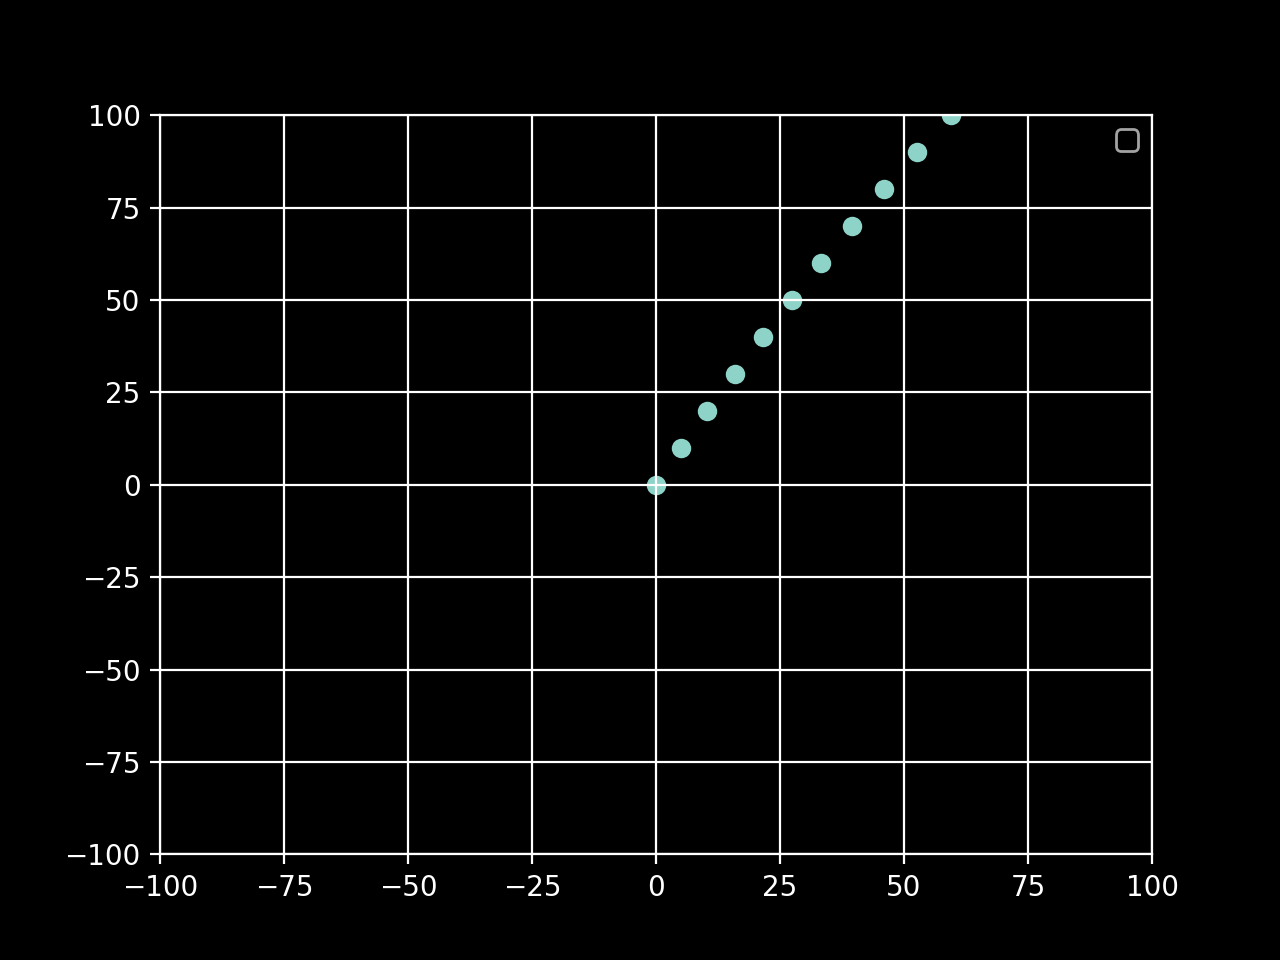

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [31]:
import os
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams['axes.grid'] = True
plt.style.use('dark_background')


def two_body_eqm(_y, _t, _G, _m1, _m2):
    """
    differential equations of motion describing the two-body-problem
    _t: discrete time step value
    _y: state vector
    """
    # magnitude of position vector from r1 to r2
    r_mag = np.linalg.norm(_y[3:6] - _y[:3])
    c0 = _y[6:12]
    c1 = _G * _m2 * ((_y[3:6] - _y[:3]) / np.power(r_mag, 3))
    c2 = _G * _m1 * ((_y[:3] - _y[3:6]) / np.power(r_mag, 3))
    return np.concatenate((c0, c1, c2))


# ==============================================================
# simulation harness

# universal gravitation constant
# G = 6.67408e-11 (m**3/kg/s**2)
G = 6.67259e-20  # (km**3/kg/s**2)

# time array
time = np.arange(0, 480, 0.5)

# body m1 initial conditions
m1 = 1e26  # mass (kg)
r10 = np.array([0, 0, 0])  # initial position (km)
v10 = np.array([10, 20, 30])  # initial velocity (km/s)

# body m2 initial conditions
m2 = 1e26  # mass (kg)
r20 = np.array([3000, 0, 0])  # initial position (km)
v20 = np.array([0, 40, 0])  # initial velocity (km/s)

# [X1 (0), Y1 (1), Z1 (2), X2 (3), Y2 (4), Z2 (5), VX1 (6), VY1 (7), VZ1 (8), VX2 (9), VY2 (10), VZ2 (11)]
y0 = np.concatenate((r10, r20, v10, v20))

# ==============================================================
# propagate state

# simulation results
state_history = []

y = odeint(two_body_eqm, y0, time, args=(G, m1, m2))

for yk in y:
    # extract inertial positions of body 1 and body 2
    r1 = yk[:3]
    r2 = yk[3:6]

    # determine position of centre of mass
    rg = ((m1 * r1) + (m2 * r2)) / (m1 + m2)

    # position vector from m1 to m2
    r12 = r2 - r1

    # position vector from m1 to g
    r1g = rg - r1

    # position vector from g to m1
    rg1 = r1 - rg

    # position vector from g to m2
    rg2 = r2 - rg

    # save state history (yk = 0-11, rg = 12-14, r12=15-17, ...)
    state_history.append(np.concatenate((yk, rg, r12, r1g, rg1, rg2), axis=None))

# convert list to numpy array
state_history = np.array(state_history)

plot_limits = 100
fig, ax = plt.subplots()
ax.set_xlim([-plot_limits,plot_limits]) # set plot limits
ax.set_ylim([-plot_limits,plot_limits])

plt.scatter(state_history[:,0],state_history[:,1])
plt.legend()
plt.show()

# LeapFrog Method

In [12]:
def leapfrogintegrate(pos1, pos2, vel1, vel2):
    """
    pos1 = [x,y,z] array
    pos2 = [x,y,z] array
    vel1 = [x,y,z] array
    vel2 = [x,y,z] array
    """
    # Create empty arrays 
    x1 = np.zeros(N)
    y1 = np.zeros(N)
    z1 = np.zeros(N)
    x2 = np.zeros(N)
    y2 = np.zeros(N)
    z2 = np.zeros(N)
    vx1 = np.zeros(N)
    vy1 = np.zeros(N)
    vz1 = np.zeros(N)
    vx2 = np.zeros(N)
    vy2 = np.zeros(N)
    vz2 = np.zeros(N)
    
    # initialize 

    for index in range(N-1):
        if index == 0:
            x1[index] = pos1[0]
            x2[index] = pos2[0]
            y1[index] = pos1[1]
            y2[index] = pos2[1]
            z1[index] = pos1[2]
            z2[index] = pos2[2]
            vx1[index] = vel1[0]
            vx2[index] = vel2[0]
            vy1[index] = vel1[1]
            vy2[index] = vel2[1]
            vz1[index] = vel1[2]
            vz2[index] = vel2[2]
        else:
            F = G*mass_obj1*mass_obj2*(x2[index-1] - x1[index-1])/(np.linalg.norm(x2[index-1] - x1[index-1]))**3
            vx1[index] = vx1[index-1]+dt*F/mass_obj1
            vy1[index] = vy1[index-1]+dt*F/mass_obj1
            vz1[index] = vz1[index-1]+dt*F/mass_obj1
            vx2[index] = vx2[index-1]+dt*F/mass_obj2
            vy2[index] = vy2[index-1]+dt*F/mass_obj2
            vz2[index] = vz2[index-1]+dt*F/mass_obj2
            x1[index] = x1[index-1]+dt*vx1[index]
            x2[index] = x2[index-1]+dt*vx2[index]
            y1[index] = y1[index-1]+dt*vy1[index]
            y2[index] = y2[index-1]+dt*vy2[index]
            z1[index] = z1[index-1]+dt*vz1[index]
            z2[index] = z2[index-1]+dt*vz2[index]
    
    return x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2  